In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np

import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence

In [ ]:
# we will look at a simpler dataframe . (This is only the categorical columns of the income dataset)
df = pd.read_csv('/content/train.csv')
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
income = df[categorical_columns]

In [ ]:
income.head()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country
0,Private,Doctorate,Divorced,Exec-managerial,Not-in-family,White,Male,United-States
1,Private,12th,Never-married,Other-service,Own-child,White,Male,United-States
2,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
3,State-gov,7th-8th,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
4,State-gov,Some-college,Never-married,Other-service,Not-in-family,Black,Male,United-States


In [ ]:
# the combined vovabulary of the dataset is :
import numpy as np
vocab = []
for col in income.columns:
    vocab.append(income[col].dropna().unique())
vocab = np.hstack(vocab)
#vocab = np.unique(vocab)
len(vocab)

99

In [ ]:
# there are 9 columns so we will use all the context window as 9
# we  will use the start token as <start> and the end token as <end>
# so lets make a simpler lookup table.
vocab = list(vocab)
vocab.append("<start>")
vocab.append("<end>")
vocab.append(float('nan'))
vocab = ["<blank>"] + vocab


In [ ]:
# vocab = set(vocab) # just to be double sure 😅
len(vocab)

103

In [ ]:
vtoi = dict() # lookup for vacb to idx
itov = dict() # reverse lookup

for i,v in enumerate(vocab):
    vtoi[v]=int(i)

itov = {i:v for v,i in vtoi.items()}

In [ ]:
vtoi

{'<blank>': 0,
 'Private': 1,
 'State-gov': 2,
 'Self-emp-not-inc': 3,
 'Federal-gov': 4,
 'Local-gov': 5,
 'Self-emp-inc': 6,
 'Never-worked': 7,
 'Without-pay': 8,
 'Doctorate': 9,
 '12th': 10,
 'Bachelors': 11,
 '7th-8th': 12,
 'Some-college': 13,
 'HS-grad': 14,
 '9th': 15,
 '10th': 16,
 '11th': 17,
 'Masters': 18,
 'Preschool': 19,
 '5th-6th': 20,
 'Prof-school': 21,
 'Assoc-voc': 22,
 '1st-4th': 23,
 'Assoc-acdm': 24,
 'Divorced': 25,
 'Never-married': 26,
 'Married-civ-spouse': 27,
 'Widowed': 28,
 'Separated': 29,
 'Married-spouse-absent': 30,
 'Married-AF-spouse': 31,
 'Exec-managerial': 32,
 'Other-service': 33,
 'Transport-moving': 34,
 'Adm-clerical': 35,
 'Machine-op-inspct': 36,
 'Sales': 37,
 'Handlers-cleaners': 38,
 'Farming-fishing': 39,
 'Protective-serv': 40,
 'Prof-specialty': 41,
 'Craft-repair': 42,
 'Tech-support': 43,
 'Priv-house-serv': 44,
 'Armed-Forces': 45,
 'Not-in-family': 46,
 'Own-child': 47,
 'Husband': 48,
 'Wife': 49,
 'Unmarried': 50,
 'Other-relat

In [ ]:
# remember the start and end tokens
vtoi["<start>"] , vtoi["<end>"] , vtoi["<blank>"]

(100, 101, 0)

In [ ]:
income_copy = income.copy(deep=True)
income_copy.insert(0, "start","<start>")
income_copy["end"] = "<end>"


In [ ]:
income_encoded = income_copy.replace(vtoi).astype(int)
income_encoded

,start,workclass,education,marital-status,occupation,relationship,race,gender,native-country,end
0,100,1,9,25,32,46,52,57,59,101
1,100,1,10,26,33,47,52,57,59,101
2,100,1,11,27,32,48,52,57,59,101
3,100,2,12,27,34,48,52,57,59,101
4,100,2,13,26,33,46,53,57,59,101
...,...,...,...,...,...,...,...,...,...,...
43952,100,1,11,27,32,48,52,57,59,101
43953,100,1,14,26,33,47,52,58,59,101
43954,100,1,13,25,37,46,52,57,59,101
43955,100,1,11,26,37,46,52,58,59,101


In [ ]:
vtoi

{'<blank>': 0,
 'Private': 1,
 'State-gov': 2,
 'Self-emp-not-inc': 3,
 'Federal-gov': 4,
 'Local-gov': 5,
 'Self-emp-inc': 6,
 'Never-worked': 7,
 'Without-pay': 8,
 'Doctorate': 9,
 '12th': 10,
 'Bachelors': 11,
 '7th-8th': 12,
 'Some-college': 13,
 'HS-grad': 14,
 '9th': 15,
 '10th': 16,
 '11th': 17,
 'Masters': 18,
 'Preschool': 19,
 '5th-6th': 20,
 'Prof-school': 21,
 'Assoc-voc': 22,
 '1st-4th': 23,
 'Assoc-acdm': 24,
 'Divorced': 25,
 'Never-married': 26,
 'Married-civ-spouse': 27,
 'Widowed': 28,
 'Separated': 29,
 'Married-spouse-absent': 30,
 'Married-AF-spouse': 31,
 'Exec-managerial': 32,
 'Other-service': 33,
 'Transport-moving': 34,
 'Adm-clerical': 35,
 'Machine-op-inspct': 36,
 'Sales': 37,
 'Handlers-cleaners': 38,
 'Farming-fishing': 39,
 'Protective-serv': 40,
 'Prof-specialty': 41,
 'Craft-repair': 42,
 'Tech-support': 43,
 'Priv-house-serv': 44,
 'Armed-Forces': 45,
 'Not-in-family': 46,
 'Own-child': 47,
 'Husband': 48,
 'Wife': 49,
 'Unmarried': 50,
 'Other-relat

In [ ]:
income_decoded = income_copy.replace(itov)
income_decoded

,start,workclass,education,marital-status,occupation,relationship,race,gender,native-country,end
0,<start>,Private,Doctorate,Divorced,Exec-managerial,Not-in-family,White,Male,United-States,<end>
1,<start>,Private,12th,Never-married,Other-service,Own-child,White,Male,United-States,<end>
2,<start>,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<end>
3,<start>,State-gov,7th-8th,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,<end>
4,<start>,State-gov,Some-college,Never-married,Other-service,Not-in-family,Black,Male,United-States,<end>
...,...,...,...,...,...,...,...,...,...,...
43952,<start>,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<end>
43953,<start>,Private,HS-grad,Never-married,Other-service,Own-child,White,Female,United-States,<end>
43954,<start>,Private,Some-college,Divorced,Sales,Not-in-family,White,Male,United-States,<end>
43955,<start>,Private,Bachelors,Never-married,Sales,Not-in-family,White,Female,United-States,<end>


In [ ]:
# we will improve on seed conditions later
for i,row in income_encoded[:3].iterrows():
    context = [vtoi["<blank>"]] *(len(income.columns)+1) # take account of start token
    # predict start
    for column in income_copy.columns:
        print(context,"->",itov[ row[column]])
        context = context[1:] + [row[column]]

[0, 0, 0, 0, 0, 0, 0, 0, 0] -> <start>
[0, 0, 0, 0, 0, 0, 0, 0, 100] -> Private
[0, 0, 0, 0, 0, 0, 0, 100, 1] -> Doctorate
[0, 0, 0, 0, 0, 0, 100, 1, 9] -> Divorced
[0, 0, 0, 0, 0, 100, 1, 9, 25] -> Exec-managerial
[0, 0, 0, 0, 100, 1, 9, 25, 32] -> Not-in-family
[0, 0, 0, 100, 1, 9, 25, 32, 46] -> White
[0, 0, 100, 1, 9, 25, 32, 46, 52] -> Male
[0, 100, 1, 9, 25, 32, 46, 52, 57] -> United-States
[100, 1, 9, 25, 32, 46, 52, 57, 59] -> <end>
[0, 0, 0, 0, 0, 0, 0, 0, 0] -> <start>
[0, 0, 0, 0, 0, 0, 0, 0, 100] -> Private
[0, 0, 0, 0, 0, 0, 0, 100, 1] -> 12th
[0, 0, 0, 0, 0, 0, 100, 1, 10] -> Never-married
[0, 0, 0, 0, 0, 100, 1, 10, 26] -> Other-service
[0, 0, 0, 0, 100, 1, 10, 26, 33] -> Own-child
[0, 0, 0, 100, 1, 10, 26, 33, 47] -> White
[0, 0, 100, 1, 10, 26, 33, 47, 52] -> Male
[0, 100, 1, 10, 26, 33, 47, 52, 57] -> United-States
[100, 1, 10, 26, 33, 47, 52, 57, 59] -> <end>
[0, 0, 0, 0, 0, 0, 0, 0, 0] -> <start>
[0, 0, 0, 0, 0, 0, 0, 0, 100] -> Private
[0, 0, 0, 0, 0, 0, 0, 100, 1]

In [ ]:
X,y  = [],[]
for i,row in income_encoded.iterrows():
    context = [0]*(len(income.columns)+1) # take account of start token
    # predict start
    for column in income_copy.columns:
        X.append(context)
        y.append(row[column])
        context = context[1:] + [row[column]]

X = torch.tensor(X)
y = torch.tensor(y)

In [ ]:
X_for_gan = X[9::10,:]

In [ ]:
X_for_gan[20:50]

tensor([[100,   1,  13,  27,  34,  48,  52,  57,  59],
        [100,   1,  14,  27,  37,  48,  52,  57,  62],
        [100,   3,  14,  27,  42,  48,  52,  57,  59],
        [100,   1,  11,  27,  38,  48,  52,  57,  63],
        [100,   3,  17,  27,  42,  48,  52,  57,  59],
        [100,   1,  14,  27,  36,  48,  52,  57,  59],
        [100,   1,  13,  27,  41,  48,  52,  57,  59],
        [100,   1,  18,  27,  41,  48,  52,  57,  59],
        [100,   6,  11,  27,  32,  48,  52,  57,  59],
        [100,   1,  13,  28,  35,  50,  52,  58,  59],
        [100,   1,  13,  27,  42,  48,  52,  57,  59],
        [100,   5,  14,  25,  32,  46,  52,  58,  59],
        [100,   1,  14,  27,  32,  48,  52,  57,  59],
        [100, 102,  13,  26, 102,  47,  52,  58,  59],
        [100,   3,  14,  28,  35,  51,  52,  58,  59],
        [100,   3,  14,  26,  42,  51,  52,  57,  59],
        [100,   5,  15,  27,  33,  48,  52,  57,  59],
        [100,   1,  19,  27,  33,  48,  52,  57,  64],
        [1

In [ ]:
X_for_gan.shape

torch.Size([43957, 9])

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_va, X_ts, y_va, y_ts = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [ ]:
# train , validation and test
print(X_tr.shape, X_va.shape, X_ts.shape)
print(y_tr.shape, y_va.shape, y_ts.shape)

torch.Size([351656, 9]) torch.Size([43957, 9]) torch.Size([43957, 9])
torch.Size([351656]) torch.Size([43957]) torch.Size([43957])


In [ ]:
def mini_batch(X,y,batch_size=(32,)):
    ix = torch.randint(0,X.shape[0],size=batch_size)
    return X[ix], y[ix]

In [ ]:
X_va[:5]

tensor([[100,   1,  11,  27,  41,  48,  52,  57,  59],
        [  0, 100,   6,  11,  27,  37,  49,  52,  58],
        [100,   1,  16,  27,  34,  48,  53,  57,  59],
        [  0,   0,   0,   0, 100,   1,  13,  25,  32],
        [  0,   0,   0,   0,   0,   0,   0,   0, 100]])

In [ ]:
X_eg , y_eg = mini_batch(X_tr,y_tr)
X_eg, y_eg

(tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0, 100],
         [100,   5,  11,  26,  35,  47,  54,  58,  59],
         [  0,   0,   0,   0,   0,   0,   0,   0, 100],
         [  0,   0,   0,   0,   0, 100,   1,  11,  26],
         [  0,   0,   0,   0,   0, 100,   6,  24,  27],
         [  0,   0,   0,   0,   0,   0,   0, 100,   1],
         [  0,   0,   0, 100,   2,  18,  27,  41,  48],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0, 100,   1,  14],
         [  0, 100,   1,  11,  25,  32,  50,  52,  58],
         [100,   1,  14,  26,  35,  47,  52,  58,  59],
         [  0, 100,   5,  24,  26,  40,  50,  52,  57],
         [  0,   0, 100,   1,  14,  26,  33,  46,  52],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0, 100,   1,  13,  26,  37,  47],
         [  0,   0,   0,   0,   0,   0,   0, 100

just few single head attention in paralell

In [ ]:
class SingleHead(nn.Module):
    """
    Implements a single head of attention (unmasked)
    """

    def __init__(self,R=32,head_size=8):
        super().__init__()
        # single head
        self.head_size = torch.tensor(head_size)
        self.R = torch.tensor(R)
        self.Q = nn.Parameter( torch.randn(self.R,head_size) * (1/torch.tensor(2.82)))
        self.K = nn.Parameter( torch.randn(self.R,head_size) * (1/torch.tensor(2.82)))
        self.V = nn.Parameter( torch.randn(self.R,head_size) * (1/torch.tensor(2.82)))

    def forward(self,x):
        q = x@self.Q # (B,T,R) * (R,h) => (B,T,R) x (B,R,h) => (B,T,h)
        k = x@self.K
        v = x@self.V

        comm = q @ k.transpose(-2,-1) # (B,T,h) @ (B,h,T) => B,T,T @ each tokens interaction with each token would be T,T
        att1 = nn.functional.softmax(comm,dim=2) # along tokens head
        attention = att1 @ v # B,T,T @ B,T,h => B,T,h
        scaled_attention = attention * (1/torch.sqrt(self.head_size))
        return scaled_attention

In [ ]:
class Multihead(nn.Module):
    def __init__(self,R,head_size,n_heads):
        self.R = R
        self.head_size = head_size
        self.n_heads = n_heads

        super().__init__()
        self.multiheads = nn.ModuleList(
            [SingleHead(self.R,self.head_size)  for _ in range(self.n_heads)]
        )

    def forward(self,x):
        return torch.cat([head(x) for head in self.multiheads],dim=2)

In [ ]:
class CatMultiHeadTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self._n_embed = 32
        self._n_context_window = 9
        self.head_size = 32
        self.n_heads = 4

        # attention block
        self.multi_heads = Multihead(R=self._n_embed,
                                     head_size=self.head_size // self.n_heads,
                                     n_heads=4)

        # from word embedding (bengio 2003)
        self.C = nn.Embedding(len(vocab),self._n_embed) # some papers also do it sqrt(fan_in)

        # this time from head size not vocab length to 512 representation
        self.W1 = nn.Parameter(torch.randn(self._n_context_window * self.head_size , 512))
        torch.nn.init.kaiming_normal_(self.W1 ,nonlinearity="tanh")
        self.b1 = nn.Parameter( torch.randn(1,512) + 0.1 )


        # linear layer
        self.W2 = nn.Parameter( torch.randn(512 , len(vocab)) * 0.01)
        self.b2 = nn.Parameter( torch.randn(1,len(vocab)) + 0.1)





    def forward(self,x):
        emb = self.C(x) # B,T,R
        att = self.multi_heads(emb).view(x.shape[0],-1) # B,T,h

        h1 = torch.tanh(att@ self.W1 + self.b1)
        logits = h1 @ self.W2 + self.b2
        # loss = nn.functional.cross_entropy(logits,y)
        return logits

    def calculate_loss(self,x,y):
        logits = self(x)
        return logits , nn.functional.cross_entropy(logits,y)


    def generate(self,seed = [0] * 9,verbose=False):
        generation = list()
        i = 0
        while True:
            if i > 15:
                # clearly untrained
                break
            if verbose:
                print(seed)
            logits = self(torch.tensor(seed).view(1,-1))
            probs = nn.functional.softmax(logits,dim=1)
            prediction = torch.multinomial(probs,num_samples=1)
            generation.append(itov[ prediction.item()])
            if itov[prediction.item()] == "<end>":
                break
            seed = seed[1:] + [prediction.item()]
            if verbose:
                print(itov[prediction.item()])
            i = i+1
        return generation

    def get_embedding(self,x):
        emb = self.C(x) # B,T,R
        att = self.multi_heads(emb).view(x.shape[0],-1) # B,T,h

        h1 = torch.tanh(att@ self.W1 + self.b1)
        return h1

cat_multi = CatMultiHeadTransformer()
out = cat_multi(X_eg)


In [ ]:
optimizer = torch.optim.AdamW(cat_multi.parameters(),lr=1e-3)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [ ]:
track_loss = list()

In [ ]:

for i in tqdm(range(10_000)):
    #sample mini batch
    Xb, yb = mini_batch(X_tr,y_tr)

    # forward pass
    _,loss = cat_multi.calculate_loss(Xb,yb)

    # flush the gradients
    optimizer.zero_grad(set_to_none=True)

    # backprop
    loss.backward()

    # learning step
    optimizer.step()

    # for plotting
    track_loss.append(loss.item())
    ...

100%|██████████| 10000/10000 [00:56<00:00, 177.05it/s]


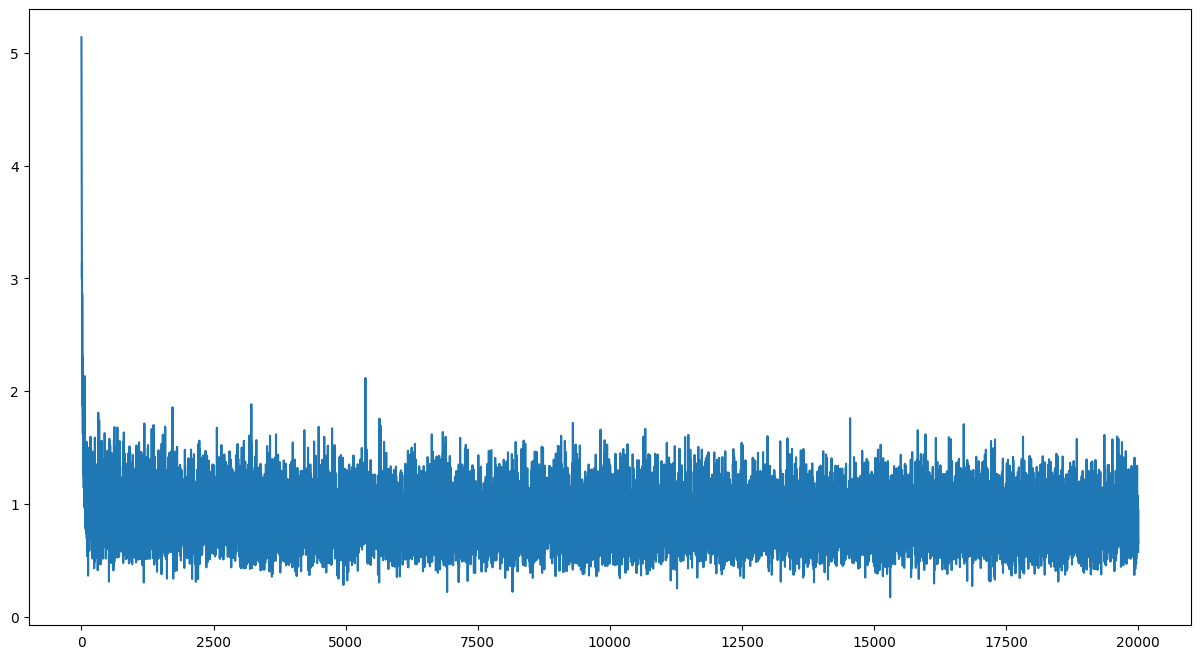

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(track_loss)
plt.show()

In [ ]:
np.median(track_loss[:-100])

0.8652625381946564

In [ ]:
cat_multi.generate()

['<start>',
 'Local-gov',
 'HS-grad',
 'Divorced',
 'Craft-repair',
 'Unmarried',
 'Amer-Indian-Eskimo',
 'Male',
 'United-States',
 '<end>']

In [ ]:
embdout = cat_multi.get_embedding(Xb[:1])

In [ ]:
embdout.shape

torch.Size([1, 512])

In [ ]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns),
    ]
)

In [ ]:
X_gan = preprocessor.fit_transform(df)

In [ ]:
metadata = []
for col in categorical_columns:
  data = df[[col]].values
  ohe = OneHotEncoder(sparse_output=False)
  ohe.fit(data)
  categories = len(ohe.categories_[0])
  metadata.append(categories)

metadata = np.array(metadata)
indices = np.zeros_like(metadata)
indices[1:] = metadata[:-1]
indices = indices.cumsum()

num_discrete_columns = len(metadata)
num_discrete_columns_options = sum(metadata)

In [ ]:
probabilities = np.zeros((num_discrete_columns, max(metadata)))
def calculate_probabilities(data):
  start_ind = 0
  for dis_col,ind in enumerate(metadata):
    tmp = np.sum(data[:, start_ind:start_ind+ind], axis=0)
    probabilities[dis_col,:ind] = tmp/np.sum(tmp)
    start_ind += ind
calculate_probabilities(X_gan)
def random_choice_prob_index(idx):
    a = probabilities[idx]
    r = np.expand_dims(np.random.rand(a.shape[0]), axis=1)
    return (a.cumsum(axis=1) > r).argmax(axis=1)
print(random_choice_prob_index([6,7]))

def datasample(batch):
  idx_cols = np.random.choice(np.arange(num_discrete_columns), batch)
  vec1 = np.zeros((batch, num_discrete_columns_options), dtype='float32')
  mask1 = np.zeros((batch, num_discrete_columns), dtype='float32')
  mask1[np.arange(batch), idx_cols] = 1
  opt1prime = random_choice_prob_index(idx_cols)
  opt1 = indices[idx_cols] + opt1prime
  #print(opt1)
  vec1[np.arange(batch), opt1] = 1

  return vec1, mask1, idx_cols, opt1prime

[ 1 38]


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
  def __init__(self, input_dim):
      super(Discriminator, self).__init__()
      self.net = nn.Sequential(
          nn.Linear(input_dim, 256),
          nn.LeakyReLU(0.2),
          nn.Linear(256, 256),
          nn.LeakyReLU(0.2),
          nn.Linear(256, 1),
          nn.Sigmoid()
      )

  def forward(self, x):
      return self.net(x)

In [ ]:
def apply_activate(data):
  data_t = []
  start_ind = 0
  for ind in metadata:
    data_t.append(F.softmax(data[:,start_ind:start_ind+ind],dim=1))
    start_ind += ind
  return torch.cat(data_t, dim=1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ConditioningAugmentation(nn.Module):
    def __init__(self, input_embedding,outputdim):
        super(ConditioningAugmentation, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.mean = nn.Linear(256, outputdim)
        self.var = nn.Linear(256, outputdim)

    def forward(self, x):
        x = self.net(x)
        return self.mean(x),F.sigmoid(self.var(x))

In [ ]:
noise_dim = 128
ca_output_dim = 32
embedding_dim = 512
generator = Generator(input_dim=(noise_dim+ca_output_dim), output_dim=X_gan.shape[1]).to(device)
discriminator = Discriminator(input_dim=X_gan.shape[1]).to(device)
ca = ConditioningAugmentation(embedding_dim,ca_output_dim)

In [ ]:
criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-4)
optimizer_ca = optim.Adam(ca.parameters(), lr=1e-4)
kl_loss = nn.KLDivLoss(reduction="batchmean")

In [ ]:
epochs = 500
batch_size = 32
steps_per_epoch = max(len(X_gan) // batch_size, 1)

In [ ]:
class Sampler:
    def __init__(self, data, output_info):
        self.data = data
        self.model = []
        self.n = len(data)
        st = 0
        for item in output_info:
                ed = st + item
                tmp = []
                for j in range(item):
                    tmp.append(np.nonzero(data[:, st + j])[0])

                self.model.append(tmp)
                st = ed

    def sample(self, n, col, opt):
        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self.model[c][o]))
        #print(idx)
        return self.data[idx],X_for_gan[idx]

In [ ]:
sampler = Sampler(X_gan,metadata)

In [169]:
G_losses = []
D_losses = []

for epoch in range(epochs):
  for steps in range(steps_per_epoch):
      noise = torch.randn(batch_size, noise_dim,dtype=torch.float32).to(device)
      condvec = datasample(batch_size)
      c1, m1, col, opt = condvec
      perm = np.arange(batch_size)
      np.random.shuffle(perm)
      real_data,inputembedding = sampler.sample(batch_size,col[perm],opt[perm])
      #print(inputembedding.shape)
      output_embedding = cat_multi.get_embedding(inputembedding).detach()
      optimizer_ca.zero_grad()
      mean,var = ca(output_embedding)
      m = MultivariateNormal(mean, var.unsqueeze(1)*torch.eye(32))
      caf_sampled = m.sample().to(device)
      #c1 = torch.from_numpy(c1).to(device)
      #m1 = torch.from_numpy(m1).to(device)
      #print(c1.shape)
      noisez = torch.cat([noise, caf_sampled], dim=1)



      optimizer_discriminator.zero_grad()

      real_labels = torch.ones(batch_size, 1).to(device)
      output_real = discriminator(torch.tensor(real_data,dtype=torch.float32).to(device))
      loss_real = criterion(output_real, real_labels)

      fake = generator(noisez)
      fakeact = apply_activate(fake)

      output_fake = discriminator(fakeact)
      fake_labels = torch.zeros(batch_size, 1).to(device)
      loss_fake = criterion(output_fake, fake_labels)

      # Combine Losses for discriminator and Update
      loss_disc = loss_real + loss_fake
      loss_disc.backward(retain_graph=True)
      optimizer_discriminator.step()

      optimizer_generator.zero_grad()
      kldiv = kl_divergence(m,MultivariateNormal(torch.zeros(ca_output_dim), torch.eye(ca_output_dim))).mean()
      output = discriminator(fakeact)
      loss_gen = criterion(output, real_labels)
      loss_gen += kldiv
      loss_gen.backward()
      optimizer_generator.step()
      optimizer_ca.step()

      G_losses.append(loss_gen.item())
      D_losses.append(loss_disc.item())

      if steps % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, epochs, steps, steps_per_epoch, loss_disc.item(), loss_gen.item(), output_real.mean().item(), output_fake.mean().item(), output.mean().item()))


Streaming output truncated to the last 5000 lines.
[321/500][600/1373]	Loss_D: 0.7995	Loss_G: 1.7737	D(x): 0.6930	D(G(z)): 0.1804 / 0.1848
[321/500][650/1373]	Loss_D: 0.6009	Loss_G: 1.6334	D(x): 0.8037	D(G(z)): 0.2119 / 0.2113
[321/500][700/1373]	Loss_D: 0.4599	Loss_G: 1.7190	D(x): 0.8743	D(G(z)): 0.1997 / 0.2013
[321/500][750/1373]	Loss_D: 0.5873	Loss_G: 1.6039	D(x): 0.8364	D(G(z)): 0.2382 / 0.2353
[321/500][800/1373]	Loss_D: 0.7309	Loss_G: 1.4995	D(x): 0.7786	D(G(z)): 0.2460 / 0.2468
[321/500][850/1373]	Loss_D: 0.5691	Loss_G: 1.7435	D(x): 0.8232	D(G(z)): 0.1905 / 0.1867
[321/500][900/1373]	Loss_D: 0.9001	Loss_G: 1.7401	D(x): 0.6495	D(G(z)): 0.1889 / 0.1938
[321/500][950/1373]	Loss_D: 0.4844	Loss_G: 1.5380	D(x): 0.8858	D(G(z)): 0.2337 / 0.2339
[321/500][1000/1373]	Loss_D: 0.7900	Loss_G: 1.6013	D(x): 0.7308	D(G(z)): 0.2344 / 0.2317
[321/500][1050/1373]	Loss_D: 0.8299	Loss_G: 1.8153	D(x): 0.6825	D(G(z)): 0.1767 / 0.1801
[321/500][1100/1373]	Loss_D: 0.5536	Loss_G: 1.7163	D(x): 0.8466	D(G

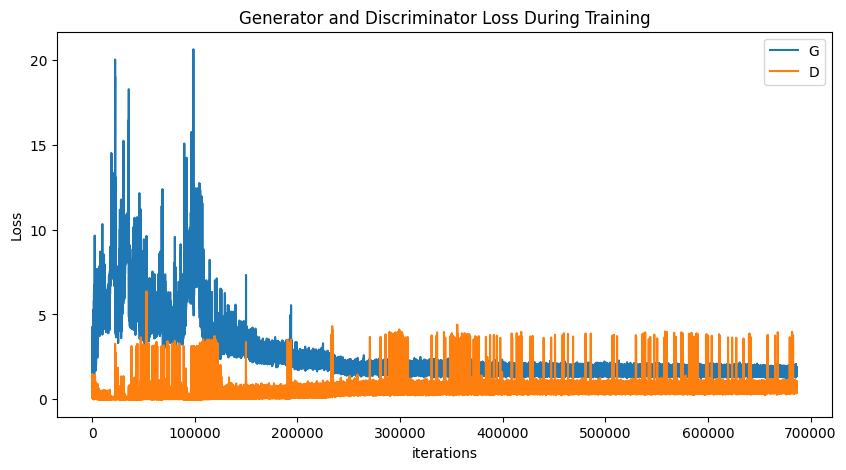

In [170]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()